In [1]:
# written by Liangying, 4/8/2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt

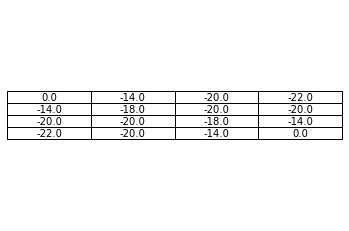

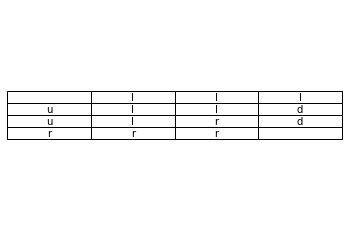

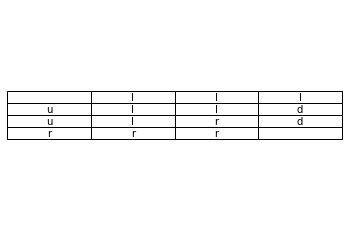

In [6]:
class Grid():
    def __init__(self, row, col, Action, Reward, discount, policy, terminal_states):
        self.row = row
        self.col = col
        self.Reward = Reward
        self.discount = discount
        self.terminal_states = terminal_states
        
        self.values = np.zeros((self.row, self.col))
        
        if policy == 'random':
            self.policy = 1 / len(Action)
        elif policy == 'best':
            self.policy = np.zeros((self.row, self.col), dtype = str)
        
        self.Action = {}
        for i,act in enumerate(Action):
            if act == 'left':
                self.Action[act] = np.array([0,-1])  
            if act == 'right':
                self.Action[act] = np.array([0,1])
            if act == 'up':
                self.Action[act] = np.array([-1,0])
            if act == 'down':
                self.Action[act] = np.array([1,0])
                
    def terminal_states_check(self,loc):
        for state in self.terminal_states:
            if (state == loc).all():   #判断行与行之间是否相等
                return True #执行到return语句时，会退出函数，return之后的语句不再执行
        return False    
        
    def Policy_evaluation_two_array(self):
        values_new = np.zeros((self.row, self.col))   #注意一定要初始化为0，因为我每来到一个新的State，这个新的State是未知的，我不知道它的值是多少，我需要通过行动来不断估计它的值
        #for i,j in product(range(0,self.row), range(0,self.col):
        for r in range(self.row):
            for c in range(self.col):
                for act in self.Action.values():
                    if self.terminal_states_check([r,c]):
                        break    # break只能跳出一层循环, continue只能跳出一次循环而不是一层循环
                    else:
                        [r_new, c_new] = np.array([r,c]) + act  #move ，必须是numpy创建的数组才能直接相加
                        if r_new < 0 or c_new < 0 or r_new >= self.row or c_new >= self.col:
                            values_new[r,c] += self.policy * (self.Reward + self.discount * self.values[r, c])   
                        else:
                            values_new[r,c] += self.policy * (self.Reward + self.discount * self.values[r_new, c_new])
        delta = np.abs(self.values - values_new)
        self.values = values_new   #注意，新的数组将成为下一轮旧的数组,或者可以理解为values_new就是个临时空间，用于存放更新完后的值，然后把新的值存到原来的全局变量self.values中去，这样就实现了全局上的就地更新
                                   #为什么这里多了一步临时数组，因为它不像前面的多臂赌博机中只在一个元素上就地更新，这里是整个数组，如果在原数组操作会影响数组元素的更新迭代
        return self.values,delta   # 这里更新的位置在循环的外面，要等都计算完了才更新
    
    # 因为概率转移是到多个状态去，自己状态的更新本身就需要+=，如果还保留着上一次迭代的状态值就会自己加自己，但是我们想要的是状态长期的回报，这个回报只包括r + v(s')，并不包括自己这个状态的本身价值。所以每次迭代需要
    # 自己状态价值变为0，但是加上别处的状态价值。所以要用一个临时变量values_new，这个变量每次都初始化为0，然后加上上一次其余状态的全局变量，再将这个临时变量传到自己状态这个全局变量中去。
    
    def Policy_evaluation_in_place(self):
        #for i,j in product(range(0,self.row), range(0,self.col):
        values_old = self.values.copy()   # 1、使用 = 直接赋值，是引用赋值，如果更改一个，另一个也会变，不管是更改a还是b，都会对对方产生影响；
                                          # 2、使用copy()，是复制一个副本，不管更改哪一个，都不会影响到对方。
        for r in range(self.row):
            for c in range(self.col):
                v = 0       #注意初始化
                for act in self.Action.values():
                    if self.terminal_states_check([r,c]):
                        break    # break只能跳出一层循环
                    else:
                        [r_new, c_new] = np.array([r,c]) + act  #move ，必须是numpy创建的数组才能直接相加
                        if r_new < 0 or c_new < 0 or r_new >= self.row or c_new >= self.col:
                            v += self.policy * (self.Reward + self.discount * self.values[r, c])
                        else:
                            v += self.policy * (self.Reward + self.discount * self.values[r_new, c_new])
                self.values[r,c] = v    # 注意更新的位置，不需要等所有矩阵都计算完后才更新，所以不需要一个临时的矩阵，而是一个变量即可。一边更新一边计算。
        delta = np.abs(values_old - self.values)
        return self.values,delta
    
    
    
    
    def Policy_str_to_ndarry(self,pi_str):
        if pi_str == 'l':
            return np.array([0,-1])  
        if pi_str == 'r':
            return np.array([0,1])
        if pi_str == 'u':
            return np.array([-1,0])
        if pi_str == 'd':
            return np.array([1,0])
    
        
    def Policy_iteration(self):
        self.policy = np.full((self.row, self.col),dtype = str,fill_value = 'l') # 对每个state，将初始策略任意初始化为向左走，但是要除去terminal state！
        self.policy[0,0] = ''
        self.policy[self.row-1, self.col-1] = ''
        
        while(True):
            # Policy evaluation_in place
            while(True):
                values_old = self.values.copy()
                for r in range(self.row):
                    for c in range(self.col):
                        if self.terminal_states_check([r,c]):
                            continue
                        else:
                            [r_new, c_new] = np.array([r,c]) + self.Policy_str_to_ndarry(self.policy[r,c])
                            if r_new < 0 or c_new < 0 or r_new >= self.row or c_new >= self.col:
                                self.values[r,c] = self.Reward + self.discount * self.values[r, c]
                            else:
                                self.values[r,c] = self.Reward + self.discount * self.values[r_new, c_new]
                delta = np.abs(values_old - self.values)
                if np.max(delta) < 1e-4:
                    break
            
            
            # Policy improvement
            policy_old = self.policy.copy()
            policy_stable = True
            for r in range(self.row):
                for c in range(self.col):
                    v_actions = np.zeros(len(self.Action))
                    for i,act in enumerate(self.Action.values()):
                        if self.terminal_states_check([r,c]):
                            break    
                        else:
                            [r_new, c_new] = np.array([r,c]) + act 
                            if r_new < 0 or c_new < 0 or r_new >= self.row or c_new >= self.col:
                                v_actions[i] = self.Reward + self.discount * self.values[r, c]
                            else:
                                v_actions[i] = self.Reward + self.discount * self.values[r_new, c_new]
                    if not self.terminal_states_check([r,c]):
                        best_action = np.argmax(v_actions)
                        self.policy[r,c] = list(self.Action)[best_action]  #获取单个key
                        if self.policy[r,c] != policy_old[r,c]:
                            policy_stable = False
                        
            if policy_stable:
                return self.policy
                break
                
        
        
    def Value_iteration(self):
        values_old = self.values.copy()
        for r in range(self.row):
            for c in range(self.col):
                v_actions = np.zeros(len(self.Action))
                for i,act in enumerate(self.Action.values()):    
                    if self.terminal_states_check([r,c]):
                        break    # break只能跳出一层循环
                    else:
                        [r_new, c_new] = np.array([r,c]) + act  #move ，必须是numpy创建的数组才能直接相加
                        if r_new < 0 or c_new < 0 or r_new >= self.row or c_new >= self.col:
                            v_actions[i] = self.Reward + self.discount * self.values[r, c]
                        else:
                            v_actions[i] = self.Reward + self.discount * self.values[r_new, c_new]
                if not self.terminal_states_check([r,c]):   #注意python中的逻辑运算符是and,or,not。不是!,~之类的与C相似的符号
                    v_best_action = np.max(v_actions)
                    best_action = np.argmax(v_actions)
                    self.policy[r,c] = list(self.Action)[best_action]  #获取单个key
                    self.values[r,c] = v_best_action
        delta = np.abs(values_old - self.values)
        return self.values, self.policy, delta
        
        
    
    def draw_fig(self, values):
        fig, ax = plt.subplots()
        ax.set_axis_off()
        plt.table(cellText = values,loc = 'center', cellLoc = 'center')
        
    
if __name__ == '__main__':
    row = 4
    col = 4
    Action = ['left','right','up','down']
    Reward = -1
    discount = 1
    policy = 'random'
    terminal_states = np.array([[0,0],[row-1,col-1]])   
    grid = Grid(row, col, Action, Reward, discount, policy, terminal_states)
    
 
    flag = 1
    while(flag):
        #values,delta = grid.Policy_iteration_two_array()
        values,delta = grid.Policy_evaluation_in_place()
        #pdb.set_trace()
        if np.max(delta) < 1e-4:
            grid.draw_fig(np.around(values,2))
            flag = 0
            
    policy = 'best'
    grid = Grid(row, col, Action, Reward, discount, policy, terminal_states)
    flag = 1
    while(flag):
        values,policy,delta = grid.Value_iteration()
        if np.max(delta) < 1e-4:
            grid.draw_fig(policy)
            flag = 0
            
            
    policy = 'best'
    discount = 0.8    #如果初始化不是random，比如都向左，一定要使discount小于1，否则无法收敛！！
    grid = Grid(row, col, Action, Reward, discount, policy, terminal_states)
    policy = grid.Policy_iteration()
    grid.draw_fig(policy)
            

In [15]:
grid.Action.keys()

dict_keys(['left', 'right', 'up', 'down'])

In [16]:
grid.Action

{'left': array([ 0, -1]),
 'right': array([0, 1]),
 'up': array([-1,  0]),
 'down': array([1, 0])}

In [18]:
for key,act in grid.Action.items():
    print(key,act)

left [ 0 -1]
right [0 1]
up [-1  0]
down [1 0]


In [20]:
list(grid.Action)[0]

'left'

In [12]:
a = np.full((3, 3),dtype = str,fill_value = 'l')

In [7]:
b = np.full((3,3), fill_value = [0,1])

ValueError: could not broadcast input array from shape (2,) into shape (3,3)

In [15]:
b

array([['', '', ''],
       ['', '', ''],
       ['', '', '']], dtype='<U1')

In [16]:
a

array([['l', 'l', 'l'],
       ['l', 'l', 'l'],
       ['l', 'l', 'l']], dtype='<U1')

In [17]:
help(np.full)

Help on function full in module numpy:

full(shape, fill_value, dtype=None, order='C', *, like=None)
    Return a new array of given shape and type, filled with `fill_value`.
    
    Parameters
    ----------
    shape : int or sequence of ints
        Shape of the new array, e.g., ``(2, 3)`` or ``2``.
    fill_value : scalar or array_like
        Fill value.
    dtype : data-type, optional
        The desired data-type for the array  The default, None, means
         ``np.array(fill_value).dtype``.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory.
    like : array_like
        Reference object to allow the creation of arrays which are not
        NumPy arrays. If an array-like passed in as ``like`` supports
        the ``__array_function__`` protocol, the result will be defined
        by it. In this case, it ensures the creation of an array object
        compatible with that pas